In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import pickle
from itertools import product
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
%matplotlib inline

sns.set(
    'paper', font_scale=2.8,
        rc={'lines.linewidth': 2,
            'text.usetex' : True,
            'image.interpolation': 'nearest',
            'image.cmap': 'gray',
            'figure.figsize': (10.0, 8.0),
            'legend.frameon': True,
            'legend.fancybox': True,
            }
       )
sns.set_style('whitegrid', {'axes.grid' : False})
sns.set_palette(sns.color_palette("colorblind",10), 10, color_codes=False)

In [10]:
res_dir = "../output/tube"

models = [
    "R_50_C4_1x",
    "R_50_FPN_1x",
    "R_101_C4_1x",
    "R_101_FPN_3x",
]
win_size = 100
min_votes = np.arange(5, 100, 5)

# comb = product(models, win_size, min_votes)

In [11]:
def fancy_mdl_names(list_mdls):
    m = [m.replace('R_', 'R') for m in list_mdls]
    m = [m.replace('_', '-') for m in m]
    m = [m[:-3] for m in m]
    return m

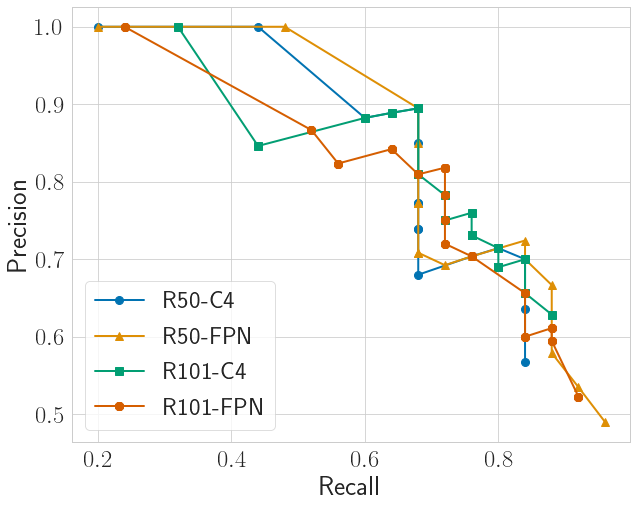

In [20]:
plt.figure()
markers = ['o', '^', 's', '8']

for m, model in enumerate(models):

    pr = []
    rc = []

    for vot in min_votes:

#         res_filename = f"faster_rcnn_{model}_size{win_size}_vot{vot}"
        res_filename = f"faster_rcnn_{model}_vot{vot}"

        res_file = open(os.path.join(res_dir, f"{res_filename}.pkl"), 'rb')
        res = pickle.load(res_file)
        res_file.close()
        
        if res['tp'] == 0:
            continue

        rc.append(res['tp'] / (res['tp'] + res['fn']) if (res['tp'] + res['fn']) != 0 else 0)
        pr.append(res['tp'] / (res['tp'] + res['fp']) if (res['tp'] + res['fp']) != 0 else 0)
        

    plt.plot(rc, pr, '-', marker=markers[m], markersize=8)

plt.legend(fancy_mdl_names(models))
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.yscale('log')
# plt.xscale('log')


# plt.plot([0,1],[1,0]) # 

# plt.xlim([0.15, 1.0])
# plt.ylim([0.45, 1.05])
plt.grid()

plt.show()

In [7]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import get_detection_dataset_dicts, MetadataCatalog

import pickle
import contextlib
from fvcore.common.file_io import PathManager
from pycocotools.coco import COCO
import io


In [7]:
model_name = 'faster_rcnn_R_101_C4_1x'

In [8]:
register_coco_instances("test", 
                        {},
                        f"../codes/preds_{model_name}.json",
                        "../data/_under_construction/frames")

In [9]:
metadata = MetadataCatalog.get("test")
json_file = PathManager.get_local_path(metadata.json_file)
with contextlib.redirect_stdout(io.StringIO()):
    coco_api = COCO(json_file)

In [10]:
dataset_dicts = get_detection_dataset_dicts(["test"], filter_empty=False)    


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [11]:
import cv2
import torch
from detectron2.structures.boxes import BoxMode

import sys
sys.path.append('../codes')
from utils.img_utils import add_bboxes_on_image

In [12]:
coco_api.getImgIds(imgIds=[0])

[0]

In [13]:
def get_res(sample):
    img = cv2.imread(sample["file_name"])
        
    bbs_gt = (torch.tensor([d['bbox'] for d in sample['annotations']])) 
    if len(bbs_gt):
        bbs_gt = BoxMode.convert(bbs_gt, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
        img = add_bboxes_on_image(img, bbs_gt, color=(0, 0, 255))

    
    def get_preds(preds, img_id):    
        for pred in preds:
            instances = pred["instances"]        
            if  pred["image_id"] == img_id:
                break    
        return instances
    
    preds = get_preds(predictions, sample["image_id"])
    bbs_pred = (torch.tensor([d['bbox'] for d in preds])) 
    
    print(bbs_pred)
    
    if len(bbs_pred):
        bbs_pred = BoxMode.convert(bbs_pred, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
        img = add_bboxes_on_image(img, bbs_pred, color=(255,0,0))
    
    return img[:,:, ::-1] 